# Producing the Julia Microbenchmarks plot

In [1]:
] activate .

In [2]:
# ] instantiate

In [3]:
# Load the required Julia packages
using DataFrames
using Gadfly
using CSV
using StatsBase

┌ Info: Recompiling stale cache file C:\Users\carsten\.julia\compiled\v1.1\Gadfly\DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1184


In [4]:
# Load benchmark data from file
benchmarks = CSV.read("benchmarks.csv"; header=["language", "benchmark", "time"])

# Capitalize and decorate language names from datafile
dict = Dict("c"=>"C", "julia"=>"Julia", "lua"=>"LuaJIT", "fortran"=>"Fortran", "java"=>"Java",
    "javascript"=>"JavaScript", "matlab"=>"Matlab", "mathematica"=>"Mathematica", 
    "python"=>"Python", "octave"=>"Octave", "r"=>"R", "rust"=>"Rust", "go"=>"Go");
benchmarks[!, :language] = [dict[lang] for lang in benchmarks[!, :language]]

# Normalize benchmark times by C times
ctime = benchmarks[benchmarks[!, :language].== "C", :]
benchmarks = join(benchmarks, ctime, on=:benchmark, makeunique=true)
select!(benchmarks, Not(:language_1))
rename!(benchmarks, :time_1 =>:ctime)
benchmarks[!, :normtime] = benchmarks[!, :time] ./ benchmarks[!, :ctime];

# Compute the geometric mean for each language
langs = [];
means = [];
priorities = [];
for lang in values(dict)
    data = benchmarks[benchmarks[!, :language].== lang, :]
    gmean = geomean(data[!, :normtime])
    push!(langs, lang)
    push!(means, gmean)
    if (lang == "C")
        push!(priorities, 1)
    elseif (lang == "Julia")
        push!(priorities, 2)        
    else
        push!(priorities, 3)
    end
end

# Add the geometric means back into the benchmarks dataframe
langmean = DataFrame(language=langs, geomean = means, priority = priorities)
benchmarks = join(benchmarks, langmean, on=:language)

# Put C first, Julia second, and sort the rest by geometric mean
sort!(benchmarks, [:priority, :geomean]);
sort!(langmean,   [:priority, :geomean]);

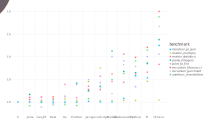

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = evalmapping(::DataFrame, ::Symbol) at dataframes.jl:96
└ @ Gadfly C:\Users\carsten\.julia\packages\Gadfly\1wgcD\src\dataframes.jl:96


In [5]:
p = plot(benchmarks,
    x = :language,
    y = :normtime,
    color = :benchmark,
    Scale.y_log10,
    Guide.ylabel(nothing),
    Guide.xlabel(nothing),
    Coord.Cartesian(xmin=1,xmax=13.3,ymin=-0.5,ymax=4.2),
    Theme(
        guide_title_position = :left,
        colorkey_swatch_shape = :circle,
        minor_label_font = "Georgia",
        major_label_font = "Georgia"
    ),
)
draw(SVG(8inch,8inch/MathConstants.golden), p)

In [6]:
draw(SVG("benchmarks.svg", 9inch, 9inch/MathConstants.golden), p)

false

In [7]:
# Show geometric means of microbenchmarks by language
sort(langmean[:,1:2], :geomean)

,language,geomean
,Any,Any
1,C,1.0
2,LuaJIT,1.09231
3,Rust,1.0999
4,Julia,1.17006
5,Go,1.49917
6,Fortran,1.67022
7,Java,3.46773
8,JavaScript,4.79602
9,Matlab,9.57235


# Alternative plot

In [8]:
using Plots, StatsPlots

┌ Info: Recompiling stale cache file C:\Users\carsten\.julia\compiled\v1.1\Plots\ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file C:\Users\carsten\.julia\compiled\v1.1\StatsPlots\SiylL.ji for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1184


In [9]:
plotly()

Plots.PlotlyBackend()

In [10]:
names(benchmarks)

7-element Array{Symbol,1}:
 :language 
 :benchmark
 :time     
 :ctime    
 :normtime 
 :geomean  
 :priority 

In [18]:
p = @df benchmarks Plots.plot(:language, :normtime, group=:benchmark, m=:circle, l=false, yscale=:log10, legend=:best, seriestype=:scatter)

In [23]:
savefig(p, "alternative.png")

MethodError: MethodError: no method matching _show(::IOStream, ::MIME{Symbol("image/png")}, ::Plots.Plot{Plots.PlotlyBackend})
Closest candidates are:
  _show(::IO, !Matched::MIME{Symbol("text/html")}, ::Plots.Plot{Plots.PlotlyBackend}) at C:\Users\carsten\.julia\packages\Plots\gylTh\src\backends\plotly.jl:859
  _show(::IO, !Matched::MIME{Symbol("text/html")}, ::Plots.Plot) at C:\Users\carsten\.julia\packages\Plots\gylTh\src\output.jl:163
  _show(::IO, !Matched::MIME{Symbol("text/plain")}, ::Plots.Plot) at C:\Users\carsten\.julia\packages\Plots\gylTh\src\output.jl:204
  ...